In [6]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [7]:
import pandas as pd
df = pd.read_csv('/content/drive/MyDrive/Colab Data/complaints.csv.zip')
df.iloc[:,:10].head()

,Date received,Product,Sub-product,Issue,Sub-issue,Consumer complaint narrative,Company public response,Company,State,ZIP code
0,2019-09-24,Debt collection,I do not know,Attempts to collect debt not owed,Debt is not yours,transworld systems inc. \nis trying to collect...,NaN,TRANSWORLD SYSTEMS INC,FL,335XX
1,2019-09-19,"Credit reporting, credit repair services, or o...",Credit reporting,Incorrect information on your report,Information belongs to someone else,NaN,Company has responded to the consumer and the ...,Experian Information Solutions Inc.,PA,15206
2,2019-11-08,Debt collection,I do not know,Communication tactics,Frequent or repeated calls,"Over the past 2 weeks, I have been receiving e...",NaN,"Diversified Consultants, Inc.",NC,275XX
3,2019-09-15,Debt collection,Other debt,Attempts to collect debt not owed,Debt was result of identity theft,Pioneer has committed several federal violatio...,NaN,Pioneer Capital Solutions Inc,CA,925XX
4,2021-03-02,"Credit reporting, credit repair services, or o...",Credit reporting,Incorrect information on your report,Information belongs to someone else,NaN,NaN,"EQUIFAX, INC.",FL,33325


In [8]:
df = df[pd.notnull(df['Consumer complaint narrative'])]

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 679285 entries, 0 to 1999963
Data columns (total 18 columns):
 #   Column                        Non-Null Count   Dtype 
---  ------                        --------------   ----- 
 0   Date received                 679285 non-null  object
 1   Product                       679285 non-null  object
 2   Sub-product                   627113 non-null  object
 3   Issue                         679285 non-null  object
 4   Sub-issue                     528206 non-null  object
 5   Consumer complaint narrative  679285 non-null  object
 6   Company public response       339012 non-null  object
 7   Company                       679285 non-null  object
 8   State                         675680 non-null  object
 9   ZIP code                      528244 non-null  object
 10  Tags                          111909 non-null  object
 11  Consumer consent provided?    679285 non-null  object
 12  Submitted via                 679285 non-null  object
 13

In [10]:
col = ['Product', 'Consumer complaint narrative']
df = df[col]

In [11]:
df.columns

Index(['Product', 'Consumer complaint narrative'], dtype='object')

In [12]:
df.columns = ['Product', 'Consumer_complaint_narrative']

In [13]:
df['category_id'] = df['Product'].factorize()[0]

In [14]:
from io import StringIO
category_id_df = df[['Product', 'category_id']].drop_duplicates().sort_values('category_id')

# Mapping Dictionaries
category_to_id = dict(category_id_df.values)
id_to_category = dict(category_id_df[['category_id', 'Product']].values)

In [15]:
df.head()

,Product,Consumer_complaint_narrative,category_id
0,Debt collection,transworld systems inc. \nis trying to collect...,0
2,Debt collection,"Over the past 2 weeks, I have been receiving e...",0
3,Debt collection,Pioneer has committed several federal violatio...,0
8,"Credit reporting, credit repair services, or o...","Previously, on XX/XX/XXXX, XX/XX/XXXX, and XX/...",1
9,"Credit reporting, credit repair services, or o...",Hello This complaint is against the three cred...,1


In [16]:
import sys
sys.getsizeof(df)/(1024**3)

0.7826486974954605

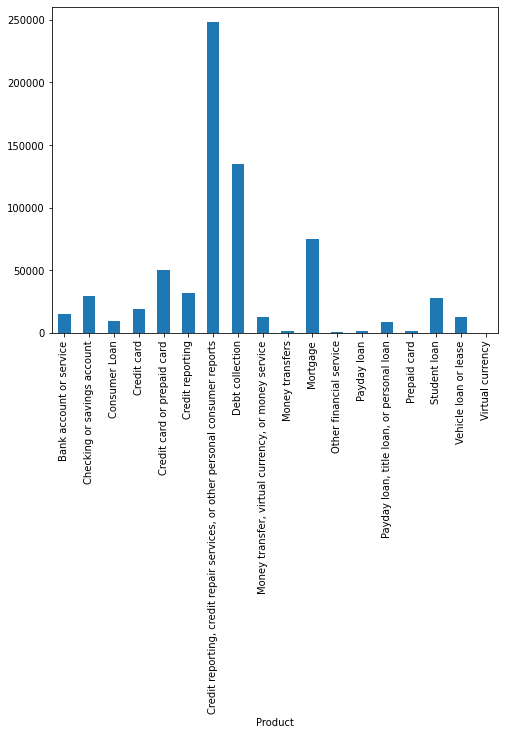

In [17]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(8,6))
df.groupby('Product').Consumer_complaint_narrative.count().plot.bar(ylim=0)
plt.show()

# Undersample the High Frequency Classes - Using Median Count

In [18]:
df['Product'].value_counts()

Credit reporting, credit repair services, or other personal consumer reports    248115
Debt collection                                                                 134651
Mortgage                                                                         75042
Credit card or prepaid card                                                      50365
Credit reporting                                                                 31588
Checking or savings account                                                      29404
Student loan                                                                     27735
Credit card                                                                      18838
Bank account or service                                                          14885
Money transfer, virtual currency, or money service                               12994
Vehicle loan or lease                                                            12287
Consumer Loan                              

In [19]:
print('Minority Class Count : ', df['Product'].value_counts().min())
print('Majority Class Count : ', df['Product'].value_counts().max())

Minority Class Count :  16
Majority Class Count :  248115


In [20]:
# Percentage of majority relative to the minority class
samplingStrategy = 0.01

In [21]:
import numpy as np

# Undersampling using sampling strategy 
nsamples_per_class = np.int16(df['Product'].value_counts().min()/samplingStrategy)
undersample = lambda df: df.loc[np.random.choice(a=df.index, size=min(len(df.index), nsamples_per_class), replace=False)]
df_bal = df.groupby(['Product'], as_index=False).apply(undersample)

print(df_bal.shape)

(25655, 3)


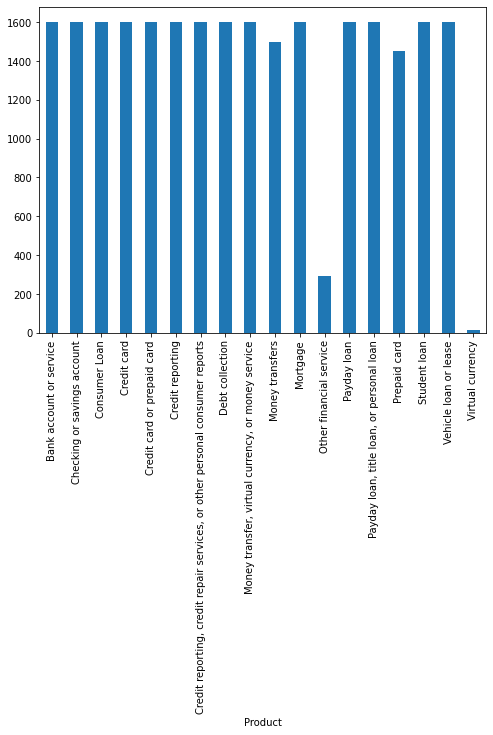

In [22]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(8,6))
df_bal.groupby('Product').Consumer_complaint_narrative.count().plot.bar(ylim=0)
plt.show()

In [23]:
df = df_bal

In [24]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(sublinear_tf=True, min_df=5, norm='l2', encoding='latin-1', ngram_range=(1, 2), stop_words='english')

features = tfidf.fit_transform(df.Consumer_complaint_narrative)
labels = df.category_id
features.shape

(25655, 70409)

In [25]:
import sys
sys.getsizeof(features)/(1024**3)

5.960464477539063e-08

In [26]:
from sklearn.feature_selection import chi2
import numpy as np

N = 2
df_feat = pd.DataFrame(columns=['Product', 'Unigrams', 'Bigrams'])

for product, category_id in sorted(category_to_id.items()):
  features_chi2 = chi2(features, labels == category_id)
  indices = np.argsort(features_chi2[0])

  feature_names = np.array(tfidf.get_feature_names())[indices]
  unigrams = [v for v in feature_names if len(v.split(' ')) == 1]
  bigrams = [v for v in feature_names if len(v.split(' ')) == 2]

  # Top N most correlated unigrams and bigrams for each category
  df_cat = pd.DataFrame(index=range(N), columns=['Product', 'Unigrams', 'Bigrams'])
  df_cat['Product'] = product
  df_cat['Unigrams'] = unigrams[-N:]
  df_cat['Bigrams'] = bigrams[-N:]
  
  df_feat = pd.concat([df_feat, df_cat], axis=0, ignore_index=True)

In [27]:
df_feat.head(20)

,Product,Unigrams,Bigrams
0,Bank account or service,citigold,overdraft fees
1,Bank account or service,overdraft,checking account
2,Checking or savings account,branch,00 bonus
3,Checking or savings account,bonus,checking account
4,Consumer Loan,vehicle,car loan
5,Consumer Loan,car,auto loan
6,Credit card,macy,annual fee
7,Credit card,card,credit card
8,Credit card or prepaid card,comenity,card xx
9,Credit card or prepaid card,card,credit card


In [28]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer, TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB

X_train, X_test, y_train, y_test = train_test_split(df['Consumer_complaint_narrative'], df['Product'], random_state = 0)

count_vect = CountVectorizer()
X_train_counts = count_vect.fit_transform(X_train)
tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)

# Baseline Classifiers

- Logistic Regression
- (Multinomial) Naive Bayes
- Linear Support Vector Machine
- Random Forest

# Optimize Baseline Models Using GridSearchCV

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC

from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV

## Multinomial Naive Bayes Classifier

In [ ]:
# Implement the grid search
pipe = Pipeline([("vectorizer", CountVectorizer()), 
                 ("classifier", MultinomialNB())])

params = {'vectorizer__ngram_range':[(1,1), (1,2)], 
          'classifier__alpha':[1, 0.1]}

gridCV = GridSearchCV(pipe, param_grid=params)

# Train the Multinomial Naive Bayes classifier  
gridCV.fit(X_train, y_train)

In [ ]:
print(gridCV.best_params_)
print(gridCV.best_score_)

{'classifier__alpha': 0.1, 'vectorizer__ngram_range': (1, 2)}
0.6179514456599413


In [ ]:
# Evaluate the Multinomial Naive Bayes classifier
y_pred = gridCV.best_estimator_.predict(X_test)
print(classification_report(y_test, y_pred))

                                                                              precision    recall  f1-score   support

                                                     Bank account or service       0.56      0.51      0.53       402
                                                 Checking or savings account       0.57      0.64      0.60       405
                                                               Consumer Loan       0.53      0.36      0.43       370
                                                                 Credit card       0.54      0.50      0.52       412
                                                 Credit card or prepaid card       0.53      0.54      0.53       401
                                                            Credit reporting       0.61      0.68      0.64       409
Credit reporting, credit repair services, or other personal consumer reports       0.56      0.56      0.56       386
                                                       

## Logistic Regression Classifier

In [ ]:
# Implement the grid search
pipe = Pipeline([('vectorizer', CountVectorizer()), 
                 ('classifier', LogisticRegression())])

params = {'vectorizer__ngram_range':[(1,1), (1,2)], 
          'classifier__C':[0.5, 1],
          'classifier__penalty':['l2', None]}
          
gridCV = GridSearchCV(pipe, param_grid=params)

# Train the Logistic Regression classifier
gridCV.fit(X_train, y_train)

In [ ]:
print(gridCV.best_params_)
print(gridCV.best_score_)

{'classifier__C': 0.5, 'classifier__penalty': 'l2', 'vectorizer__ngram_range': (1, 2)}
0.6092717605188377


In [ ]:
# Evaluate the Logistic Regression classifier
y_pred = gridCV.best_estimator_.predict(X_test)
print(classification_report(y_test, y_pred))

                                                                              precision    recall  f1-score   support

                                                     Bank account or service       0.53      0.50      0.52       402
                                                 Checking or savings account       0.55      0.60      0.57       405
                                                               Consumer Loan       0.50      0.48      0.49       370
                                                                 Credit card       0.58      0.52      0.55       412
                                                 Credit card or prepaid card       0.51      0.52      0.51       401
                                                            Credit reporting       0.66      0.64      0.65       409
Credit reporting, credit repair services, or other personal consumer reports       0.52      0.57      0.55       386
                                                       

## Linear Support Vector Machine Classifier

In [ ]:
# Implement the grid search
pipe = Pipeline([('vectorizer', CountVectorizer()), 
                 ('classifier', LinearSVC())])

params = {'vectorizer__ngram_range':[(1,1), (1,2)], 
          'classifier__loss':['squared_hinge', 'hinge']}
          
gridCV = GridSearchCV(pipe, param_grid=params)

# Train the Linear SVC classifier
gridCV.fit(X_train, y_train)

In [ ]:
print(gridCV.best_params_)
print(gridCV.best_score_)

{'classifier__loss': 'squared_hinge', 'vectorizer__ngram_range': (1, 2)}
0.5665506039044621


In [ ]:
# Evaluate the Linear SVC classifier
y_pred = gridCV.best_estimator_.predict(X_test)
print(classification_report(y_test, y_pred))

                                                                              precision    recall  f1-score   support

                                                     Bank account or service       0.49      0.45      0.46       402
                                                 Checking or savings account       0.52      0.51      0.51       405
                                                               Consumer Loan       0.43      0.41      0.42       370
                                                                 Credit card       0.49      0.47      0.48       412
                                                 Credit card or prepaid card       0.45      0.44      0.44       401
                                                            Credit reporting       0.60      0.63      0.62       409
Credit reporting, credit repair services, or other personal consumer reports       0.49      0.53      0.51       386
                                                       

## Random Forest Classifier

In [ ]:
# Implement the grid search
pipe = Pipeline([('vectorizer', CountVectorizer()), 
                 ('classifier', RandomForestClassifier())])

params = {'vectorizer__ngram_range':[(1,1), (1,2)], 
          'classifier__n_estimators':[50, 100],
          'classifier__max_depth':[2, 3],
          'classifier__random_state':[0, None]}
          
gridCV = GridSearchCV(pipe, param_grid=params)

# Train the Random Forest classifier
gridCV.fit(X_train, y_train)

In [ ]:
print(gridCV.best_params_)
print(gridCV.best_score_)

{'classifier__max_depth': 3, 'classifier__n_estimators': 100, 'classifier__random_state': 0, 'vectorizer__ngram_range': (1, 1)}
0.4719076802085376


In [ ]:
# Evaluate the Random Forest classifier
y_pred = gridCV.best_estimator_.predict(X_test)
print(classification_report(y_test, y_pred))

                                                                              precision    recall  f1-score   support

                                                     Bank account or service       0.44      0.37      0.40       402
                                                 Checking or savings account       0.45      0.51      0.48       405
                                                               Consumer Loan       0.39      0.22      0.29       370
                                                                 Credit card       0.47      0.43      0.45       412
                                                 Credit card or prepaid card       0.50      0.37      0.43       401
                                                            Credit reporting       0.60      0.58      0.59       409
Credit reporting, credit repair services, or other personal consumer reports       0.29      0.50      0.37       386
                                                       

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# Model Selection using Cross Validation

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC

from sklearn.model_selection import cross_val_score

models = [
    RandomForestClassifier(n_estimators=100, max_depth=3, random_state=0),
    LinearSVC(),
    MultinomialNB(alpha=0.1),
    LogisticRegression(C=0.5, random_state=0),
]
CV = 5
cv_df = pd.DataFrame(index=range(CV * len(models)))
entries = []
for model in models:
  model_name = model.__class__.__name__
  accuracies = cross_val_score(model, features, labels, scoring='accuracy', cv=CV)

  for fold_idx, accuracy in enumerate(accuracies):
    entries.append((model_name, fold_idx, accuracy))
    
cv_df = pd.DataFrame(entries, columns=['model_name', 'fold_idx', 'accuracy'])

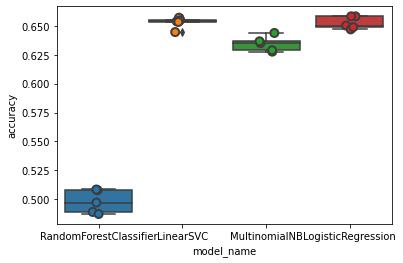

In [ ]:
import seaborn as sns

sns.boxplot(x='model_name', y='accuracy', data=cv_df)
sns.stripplot(x='model_name', y='accuracy', data=cv_df, 
              size=8, jitter=True, edgecolor="gray", linewidth=2)
plt.show()

In [ ]:
cv_df.groupby('model_name').accuracy.mean()

model_name
LinearSVC                 0.652855
LogisticRegression        0.652621
MultinomialNB             0.634496
RandomForestClassifier    0.497759
Name: accuracy, dtype: float64

# Best Model

In [35]:
from sklearn.svm import LinearSVC
from sklearn.model_selection import train_test_split

model = LinearSVC()

X_train, X_test, y_train, y_test, indices_train, indices_test = train_test_split(features, labels, df.index, test_size=0.33, random_state=0)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

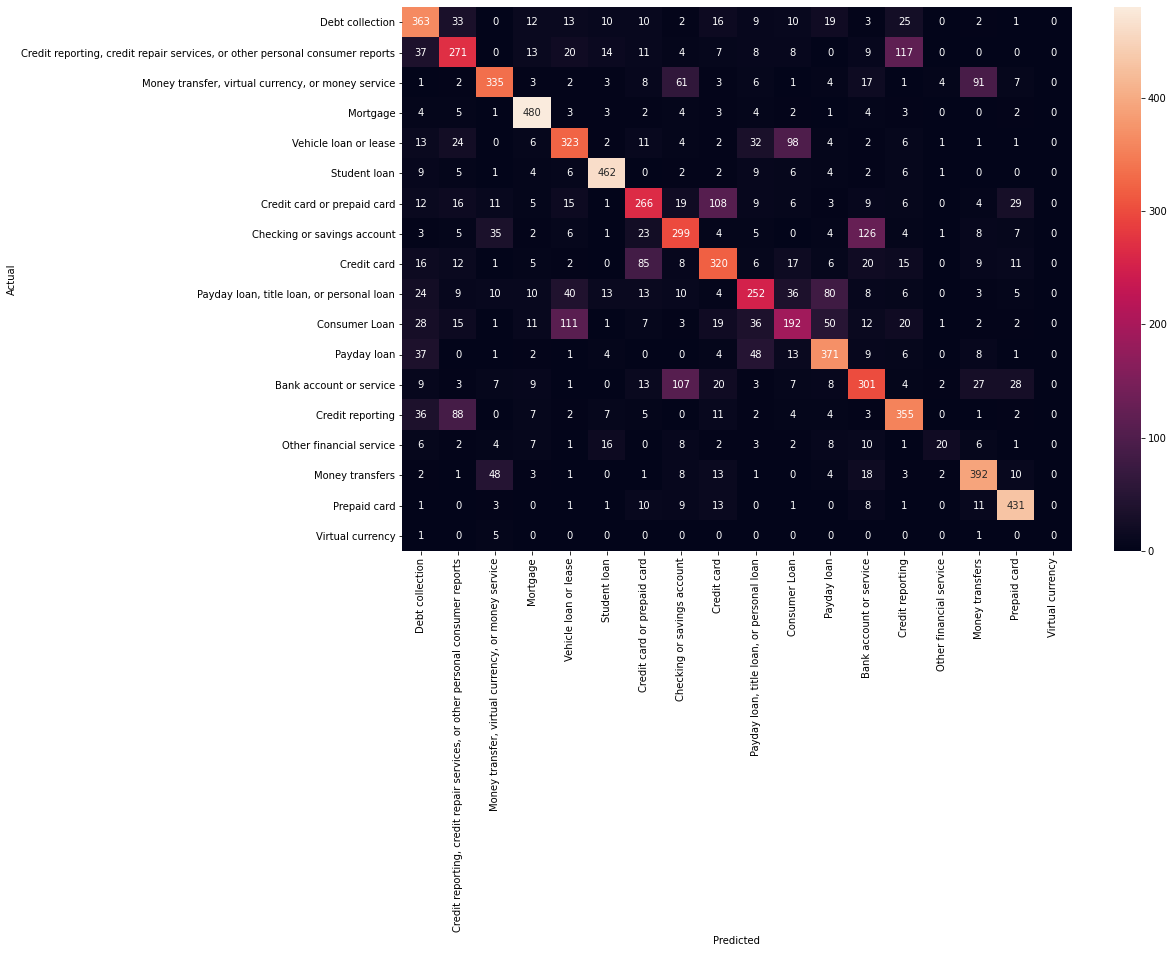

In [37]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

conf_mat = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots(figsize=(15,10))
sns.heatmap(conf_mat, annot=True, fmt='d',
            xticklabels=category_id_df.Product.values, yticklabels=category_id_df.Product.values)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

In [48]:
from IPython.display import display

for predicted in category_id_df.category_id:
  for actual in category_id_df.category_id:
    if predicted != actual and conf_mat[actual, predicted] >= 100:
      print("'{}' predicted as '{}' : {} examples.".format(id_to_category[actual], id_to_category[predicted], conf_mat[actual, predicted]))
      display(df.loc[indices_test[(y_test == actual) & (y_pred == predicted)]][['Product', 'Consumer_complaint_narrative']])
      print('')

'Consumer Loan' predicted as 'Vehicle loan or lease' : 111 examples.


Product                       Consumer_complaint_narrative
2 1675296  Consumer Loan  I had a car financed with Hyundai Motor Financ...
  1687766  Consumer Loan  In XXXX of 2015, I ( my son ) returned a Buick...
  1061222  Consumer Loan  On XX/XX/2016 I paid the balance to Hyundai fo...
  1656182  Consumer Loan  History : I submitted a insurance payout check...
  1709593  Consumer Loan  I BANK FINANCED A CAR AT A CAR LOT CAR HAD PAP...
...                  ...                                                ...
  1773736  Consumer Loan  I got my car from the dealer and I realized 6 ...
  1661208  Consumer Loan  At the beginning of XXXX 2015 I applied to Nav...
  1676597  Consumer Loan  Applied for a vehicle loan online with no cred...
  1034737  Consumer Loan  My vehicle lease and auto loan are paid in ful...
  1636929  Consumer Loan  I leased a Regal Buick XX/XX/XXXX, 3 years ago...

[111 rows x 2 columns]


'Bank account or service' predicted as 'Checking or savings account' : 107 examples.


Product                       Consumer_complaint_narrative
0 1667477  Bank account or service  When I left my last employer, my 401k account ...
  1642317  Bank account or service  I was the victim of a scam/fraud on my bank ac...
  1631765  Bank account or service  Wells Fargo authorized and paid a POS transact...
  1781815  Bank account or service  US Bank applies over draft fee 's on my accoun...
  1727898  Bank account or service  I deposited a check for XXXX XX/XX/XXXX, the c...
...                            ...                                                ...
  1742995  Bank account or service  On XX/XX/XXXX I responded to a flyer mailed to...
  1691965  Bank account or service  We opened an account with PNC earlier this wee...
  1622518  Bank account or service  My ex-husband forged my signature, deposited a...
  1602649  Bank account or service  I deposited a check for {$1400.00} into my acc...
  1723703  Bank account or service  For the second time TD bank has closed my debi...

[107 rows x 2 columns]


'Credit card or prepaid card' predicted as 'Credit card' : 108 examples.


Product                       Consumer_complaint_narrative
4 815513   Credit card or prepaid card  USAA has violated the timeline for investigati...
  1921903  Credit card or prepaid card  In XX/XX/XXXX I was approached by a Wells Farg...
  153514   Credit card or prepaid card  JP Morgan Chase defrauds credit card customers...
  1995261  Credit card or prepaid card  I opened a business credit card from Wells Far...
  275362   Credit card or prepaid card  I paid off my credit card balance in full, and...
...                                ...                                                ...
  445198   Credit card or prepaid card  On Monday XX/XX/XXXX, I called Capital One reg...
  1988504  Credit card or prepaid card  Applied for capital one credit card and got ac...
  866954   Credit card or prepaid card  On XXXX XXXX, 2016 an XXXX credit card from Ch...
  877250   Credit card or prepaid card  On XXXX/XXXX/XXXX I paid m XXXX XXXX XXXX XXXX...
  1970874  Credit card or prepaid card  Capital one is driving me crazy its been a whi...

[108 rows x 2 columns]


'Checking or savings account' predicted as 'Bank account or service' : 126 examples.


Product                       Consumer_complaint_narrative
1 1914732  Checking or savings account  I filed a dispute with Wells Fargo Bank in reg...
  71589    Checking or savings account  see attachments new information compiled by a ...
  825777   Checking or savings account  To whom it may concern, XXXX XXXX, 2017 My nam...
  51174    Checking or savings account  I went in to deposit my healthcare checks they...
  526932   Checking or savings account  1- withdrew {$20.00} 2- went to redeposit {$20...
...                                ...                                                ...
  84439    Checking or savings account  On XX/XX/2019 I submitted a written request to...
  1892204  Checking or savings account  I'm getting duplicate overdraft fees that feel...
  924755   Checking or savings account  Fifth Third Bank has a deposit practice of " h...
  674204   Checking or savings account  I previously owed money to two banks in 2016 ....
  110563   Checking or savings account  Hello, I have information that may help your c...

[126 rows x 2 columns]


'Credit reporting, credit repair services, or other personal consumer reports' predicted as 'Credit reporting' : 117 examples.


Product                       Consumer_complaint_narrative
6 1957512  Credit reporting, credit repair services, or o...  I am absolutely in disbelief that there are so...
  786204   Credit reporting, credit repair services, or o...  I reported to  XXXX  an error on my report tha...
  39658    Credit reporting, credit repair services, or o...  I have indicated to the credit bureau as well ...
  776110   Credit reporting, credit repair services, or o...  I am subscribed to many services that offer yo...
  276164   Credit reporting, credit repair services, or o...  Attention : Consumer Relations, I recently obt...
...                                                      ...                                                ...
  161702   Credit reporting, credit repair services, or o...   XXXX wont remove the inquiries that I didnt make
  1399356  Credit reporting, credit repair services, or o...  There is an incorrect address on my equifax ac...
  1954230  Credit reporting, credit repair services, or o...  I sent Transunion a letter on XXXX, 2018 and a...
  901221   Credit reporting, credit repair services, or o...  Regaurding my XXXX account XXXX XXXX XXXX XXXX...
  36928    Credit reporting, credit repair services, or o...  I filed a dispute with Transunion requesting t...

[117 rows x 2 columns]

In [38]:
model.fit(features, labels)

LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
          intercept_scaling=1, loss='squared_hinge', max_iter=1000,
          multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
          verbose=0)

In [46]:
from sklearn.feature_selection import chi2

N = 2
df_feat = pd.DataFrame(columns=['Product', 'Unigrams', 'Bigrams'])

for product, category_id in sorted(category_to_id.items()):
  indices = np.argsort(model.coef_[category_id])
  feature_names = np.array(tfidf.get_feature_names())[indices]

  unigrams = [v for v in reversed(feature_names) if len(v.split(' ')) == 1][:N]
  bigrams = [v for v in reversed(feature_names) if len(v.split(' ')) == 2][:N]

  # Top N most correlated unigrams and bigrams for each category
  df_cat = pd.DataFrame(index=range(N), columns=['Product', 'Unigrams', 'Bigrams'])
  df_cat['Product'] = product
  df_cat['Unigrams'] = unigrams[-N:]
  df_cat['Bigrams'] = bigrams[-N:]

  df_feat = pd.concat([df_feat, df_cat], axis=0, ignore_index=True)

In [47]:
df_feat.head(30)

,Product,Unigrams,Bigrams
0,Bank account or service,bank,xx 2016
1,Bank account or service,scottrade,xx 2017
2,Checking or savings account,bank,cashed fraudulent
3,Checking or savings account,don,trying link
4,Consumer Loan,ally,personal loan
5,Consumer Loan,vehicle,vehicle loan
6,Credit card,macy,credit card
7,Credit card,card,late fees
8,Credit card or prepaid card,card,card xx
9,Credit card or prepaid card,capital,statement balance


In [43]:
texts = ["I requested a home loan modification through Bank of America. Bank of America never got back to me.",
         "It has been difficult for me to find my past due balance. I missed a regular monthly payment",
         "I can't get the money out of the country.",
         "I have no money to pay my tuition",
         "Coinbase closed my account for no reason and furthermore refused to give me a reason despite dozens of request"]

text_features = tfidf.transform(texts)
predictions = model.predict(text_features)

for text, predicted in zip(texts, predictions):
  print('"{}"'.format(text))
  print("  - Predicted as: '{}'".format(id_to_category[predicted]))
  print("")

"I requested a home loan modification through Bank of America. Bank of America never got back to me."
  - Predicted as: 'Mortgage'

"It has been difficult for me to find my past due balance. I missed a regular monthly payment"
  - Predicted as: 'Payday loan, title loan, or personal loan'

"I can't get the money out of the country."
  - Predicted as: 'Money transfers'

"I have no money to pay my tuition"
  - Predicted as: 'Student loan'

"Coinbase closed my account for no reason and furthermore refused to give me a reason despite dozens of request"
  - Predicted as: 'Money transfer, virtual currency, or money service'



In [44]:
from sklearn import metrics
print(metrics.classification_report(y_test, y_pred, 
                                    target_names=df['Product'].unique()))

                                                                              precision    recall  f1-score   support

                                                     Bank account or service       0.60      0.69      0.64       528
                                                 Checking or savings account       0.55      0.52      0.54       519
                                                               Consumer Loan       0.72      0.61      0.66       549
                                                                 Credit card       0.83      0.92      0.87       521
                                                 Credit card or prepaid card       0.59      0.61      0.60       530
                                                            Credit reporting       0.86      0.89      0.87       519
Credit reporting, credit repair services, or other personal consumer reports       0.57      0.51      0.54       519
                                                       

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [45]:
metrics.f1_score(y_test, y_pred, average='weighted')

0.635853257162235